In [1]:
from pathlib import Path
import pickle
import re

import numpy as np
import pandas as pd
from scipy import sparse

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler, KBinsDiscretizer, QuantileTransformer, RobustScaler

from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC

In [2]:
pd.options.display.max_colwidth = 50 # default - 50

In [3]:
DATA_PATH = Path('../data')
RANDOM_SEED = 17

**Data Loading**

In [4]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
valid_df = pd.read_csv(DATA_PATH/'valid.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')

**Data Cleaning**

In [5]:
train_df['title_length'] = train_df['title'].str.len().fillna(0)
valid_df['title_length'] = valid_df['title'].str.len().fillna(0)
test_df['title_length'] = test_df['title'].str.len().fillna(0)

train_df['text_length'] = train_df['text'].str.len().fillna(0)
valid_df['text_length'] = valid_df['text'].str.len().fillna(0)
test_df['text_length'] = test_df['text'].str.len().fillna(0)

In [6]:
train_df['is_title_na'] = train_df['title'].isnull().astype(np.int8)
valid_df['is_title_na'] = valid_df['title'].isnull().astype(np.int8)
test_df['is_title_na'] = test_df['title'].isnull().astype(np.int8)

train_df['is_text_na'] = train_df['text'].isnull().astype(np.int8)
valid_df['is_text_na'] = valid_df['text'].isnull().astype(np.int8)
test_df['is_text_na'] = test_df['text'].isnull().astype(np.int8)

In [7]:
length_cols = ['title_length', 'text_length']
na_cols = ['is_title_na', 'is_text_na']

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24871 entries, 0 to 24870
Data columns (total 7 columns):
label           24871 non-null object
title           19947 non-null object
text            24788 non-null object
title_length    24871 non-null float64
text_length     24871 non-null float64
is_title_na     24871 non-null int8
is_text_na      24871 non-null int8
dtypes: float64(2), int8(2), object(3)
memory usage: 1020.2+ KB


In [9]:
X_train = train_df.fillna('')
X_valid = valid_df.fillna('')
X_test = test_df.fillna('')

In [10]:
le = LabelEncoder()
X_train['class'] = le.fit_transform(X_train['label'])
X_valid['class'] = le.transform(X_valid['label'])

In [11]:
le.classes_

array(['clickbait', 'news', 'other'], dtype=object)

**Training**

In [12]:
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.columns]

In [13]:
class NBTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y=None):
        y = y.values
        
        pos_count = X[y==1].sum(0) 
        neg_count = X[y==0].sum(0)
        n = X.shape[1]
        p = (pos_count + self.alpha) / (pos_count.sum() + self.alpha * n)
        q = (neg_count + self.alpha) / (neg_count.sum() + self.alpha * n)
        self.r_ = np.log(p / q)
        return self
    
    def transform(self, X, y=None):
        return X.multiply(self.r_)

In [14]:
class TfidfVectorizerPlus(TfidfVectorizer):
    def __init__(self, fit_add=None, norm_type=None, pivot=5, slope=0.2, 
                       input='content', encoding='utf-8', decode_error='strict', 
                       strip_accents=None, lowercase=True, preprocessor=None, 
                       tokenizer=None, analyzer='word', stop_words=None, 
                       token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), 
                       max_df=1.0, min_df=1, max_features=None, vocabulary=None, 
                       binary=False, dtype=np.float64, norm='l2', 
                       use_idf=True, smooth_idf=True, sublinear_tf=False):
        super().__init__(input, encoding, decode_error,
                         strip_accents, lowercase, preprocessor,
                         tokenizer, analyzer, stop_words,
                         token_pattern, ngram_range,
                         max_df, min_df, max_features, vocabulary,
                         binary, dtype, norm,
                         use_idf, smooth_idf, sublinear_tf)
        
        self.fit_add = fit_add
        self.norm_type = norm_type
        self.pivot = pivot
        self.slope = slope
    
    def fit(self, X, y=None):
        if self.fit_add is not None:
            X_new = pd.concat([X, self.fit_add])
        else:
            X_new = X
        
        super().fit(X_new, y)
        return self
        
    def transform(self, X, y=None):
        res = super().transform(X)
            
        if self.norm_type == 'pivot_cosine':
            norm_factor = (1 - self.slope) * self.pivot + self.slope * sparse.linalg.norm(res, axis=1).reshape(-1, 1)
            res = sparse.csr_matrix(res.multiply(1 / norm_factor))
        elif self.norm_type == 'pivot_unique':
            unique_terms_num = (res > 0).sum(axis=1)
            norm_factor = (1 - self.slope) * self.pivot + self.slope * unique_terms_num
            res = sparse.csr_matrix(res.multiply(1 / norm_factor))
        elif self.norm_type is not None:
            raise ValueError('Incorrect normalization type')
            
        return res

In [114]:
pipe = Pipeline([
    ('features', FeatureUnion([
        ('title_length', Pipeline([
            ('extract', ColumnExtractor(['title_length'])),
            ('scale', KBinsDiscretizer())
        ])),
#         ('text_length', Pipeline([
#             ('extract', ColumnExtractor(['text_length'])),
#             ('scale', KBinsDiscretizer())
#         ])),
    ], 
#         transformer_weights={
#             'comment_text': 0.9,
#             'char_length': 0.1,
#         }
    )),
    ('clf', LogisticRegression())
])

In [115]:
param_grid = {
    'features__title_length__scale': [KBinsDiscretizer()],
    'features__title_length__scale__n_bins': [9], #np.linspace(2, 10, 9).astype(np.int8),
    'features__title_length__scale__encode': ['onehot'], #['onehot', 'onehot-dense', 'ordinal'],
    'features__title_length__scale__strategy': ['quantile'], #['uniform', 'quantile', 'kmeans'],
    
#     'features__text_length__scale': [KBinsDiscretizer()],
#     'features__text_length__scale__n_bins': [10], #np.linspace(10, 20, 6).astype(np.int8),
#     'features__text_length__scale__encode': ['onehot'], #['onehot', 'onehot-dense', 'ordinal'],
#     'features__text_length__scale__strategy': ['quantile'], #['uniform', 'quantile', 'kmeans'],
    
    'clf': [LogisticRegression()],
    'clf__penalty': ['l2'], # ['l1', 'l2'], # ['l2'],
    'clf__C': [5], #np.logspace(-2, 2, 5), # [2], 
    'clf__class_weight': ['balanced'], #[None, 'balanced'], #['balanced']
    'clf__random_state': [RANDOM_SEED],
    'clf__solver':  ['lbfgs'], #['lbfgs']
    'clf__max_iter': [200],             
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)

In [116]:
grid_search = GridSearchCV(pipe, param_grid, scoring='f1_macro', 
                           cv=cv, n_jobs=-1, return_train_score=True,
                           verbose=2, iid=True)

grid_search.fit(X_train, X_train['class'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s finished
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=17, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('title_length', Pipeline(memory=None,
     steps=[('extract', ColumnExtractor(columns=['title_length'])), ('scale', KBinsDiscretizer(encode='onehot', n_bins=5, strategy='quantile'))]))],
       transformer_weights=None)), ('clf'...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'features__title_length__scale': [KBinsDiscretizer(encode='onehot', n_bins=9, strategy='quantile')], 'features__title_length__scale__n_bins': [9], 'features__title_length__scale__encode': ['onehot'], 'features__title_length__scale__strategy': ['quantile'], 'clf': [LogisticRegression(C=5,..._weight': ['balanced'], 'clf__random_state': [17], 'clf__solver': ['lbfgs'], 'c

In [117]:
grid_search.best_score_, grid_search.best_params_

(0.6291436641670011,
 {'clf': LogisticRegression(C=5, class_weight='balanced', dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=200,
            multi_class='warn', n_jobs=None, penalty='l2', random_state=17,
            solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
  'clf__C': 5,
  'clf__class_weight': 'balanced',
  'clf__max_iter': 200,
  'clf__penalty': 'l2',
  'clf__random_state': 17,
  'clf__solver': 'lbfgs',
  'features__title_length__scale': KBinsDiscretizer(encode='onehot', n_bins=9, strategy='quantile'),
  'features__title_length__scale__encode': 'onehot',
  'features__title_length__scale__n_bins': 9,
  'features__title_length__scale__strategy': 'quantile'})

In [90]:
cv_results_df = pd.DataFrame(grid_search.cv_results_).T
cv_results_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
mean_fit_time,0.185752,0.144055,0.217127,0.258683,0.133547,0.194203,0.0952035,0.0534309,0.107113,0.146462,0.119129,0.20015,0.0485228,0.0494733,0.0565286,0.0517715,0.0628967,0.0601566
std_fit_time,0.0189688,0.00430548,0.00206673,0.00380003,0.00342095,0.00529182,0.0119539,0.000345111,0.00874674,0.0153941,0.00249648,0.0145957,0.0027827,0.000540972,0.00172472,0.00243366,0.000166893,0.00134802
mean_score_time,0.0115803,0.0118438,0.01232,0.00895929,0.0113152,0.00823665,0.00844193,0.00757349,0.0102959,0.00834024,0.00980341,0.0068481,0.00552821,0.0076946,0.00701225,0.00557458,0.00616026,0.00565219
std_score_time,0.000847459,0.00099957,0.000778198,0.00146532,0.000126481,0.00138068,0.00161695,2.39611e-05,0.000181437,0.00151789,0.00158703,1.54972e-05,3.40939e-05,0.0014776,0.00162518,0.000206351,2.55108e-05,7.62939e-06
param_clf,"LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced...","LogisticRegression(C=5, class_weight='balanced..."
param_clf__C,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
param_clf__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
param_clf__max_iter,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200
param_clf__penalty,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2
param_clf__random_state,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17


In [81]:
print(len(grid_search.best_estimator_.get_params()['features__text__vec'].vocabulary_))

KeyError: 'features__text__vec'

In [82]:
y_val_pred = grid_search.predict_proba(X_valid).argmax(axis=1)
y_val_pred

array([1, 1, 1, ..., 2, 1, 1])

In [83]:
le.inverse_transform(y_val_pred)

array(['news', 'news', 'news', ..., 'other', 'news', 'news'], dtype=object)

In [84]:
np.bincount(y_val_pred) / len(y_val_pred)

array([0.00253378, 0.79504505, 0.20242117])

**Evaluation**

In [85]:
f1_score(X_valid['class'], y_val_pred, average='macro')

0.5800877966646825

**Feature Importance**

**Predict & Submit**

In [ ]:
full_train_df = pd.concat([train_df, valid_df], axis=0, ignore_index=True)

In [634]:
best_model.fit(full_train_df, full_train_df['class'])

NameError: name 'best_model' is not defined

In [635]:
submission_df = pd.read_csv(DATA_PATH/'sample_submission.csv', index_col='id')
submission_df['prediction'] = best_model.predict_proba(test_df)[:, 1]
submission_df.to_csv('submission.csv')

NameError: name 'best_model' is not defined

**Error Analysis**

In [294]:
validate_df['is_correct'] = (validate_df['target_class'] == validate_df['class_pred'])
validate_df.head()

,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,target,target_class,target_pred,class_pred,is_correct
423701,False,False,False,False,False,False,False,False,False,0,0,0.147193,0,True
1088030,False,False,False,False,False,False,False,False,False,0,0,0.136164,0,True
332197,False,False,False,False,False,False,False,False,False,0,0,0.127364,0,True
849122,False,False,False,False,False,False,False,False,False,0,0,0.113174,0,True
448612,False,False,False,False,False,False,False,False,False,0,0,0.132020,0,True


In [295]:
errors_count_df = validate_df.groupby(['target_class', 'is_correct'])[identity_cols].sum().astype(np.int)
errors_count_df

male  female  homosexual_gay_or_lesbian  christian  \
target_class is_correct                                                       
0            False          0       0                          0          0   
             True        3777    4754                        783       3757   
1            False        637     726                        331        346   
             True           3       4                          1          0   

                         jewish  muslim  black  white  \
target_class is_correct                                 
0            False            0       0      0      0   
             True           692    1572   1061   1864   
1            False          112     459    426    712   
             True             0       0      1      0   

                         psychiatric_or_mental_illness  
target_class is_correct                                 
0            False                                   0  
             True                                  357  
1            False                                 112  
             True                                    0

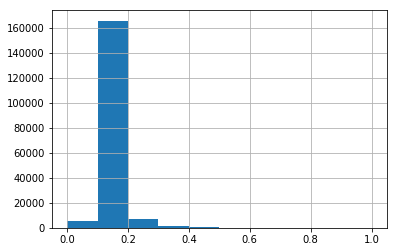

In [296]:
validate_df['target_pred'].hist()

In [297]:
error_analysis_df = pd.merge(X_valid['comment_text'], validate_df, 
                             right_index=True, left_index=True)
error_analysis_df.head()

,comment_text,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,target,target_class,target_pred,class_pred,is_correct
423701,For a historical perspective have a listen to ...,False,False,False,False,False,False,False,False,False,0,0,0.147193,0,True
1088030,""" And everyone knows what a thug Saddam Hussei...",False,False,False,False,False,False,False,False,False,0,0,0.136164,0,True
332197,Best qualified ? How so ? She is another exalt...,False,False,False,False,False,False,False,False,False,0,0,0.127364,0,True
849122,"Among its other transgressions , JPMorgan has ...",False,False,False,False,False,False,False,False,False,0,0,0.113174,0,True
448612,It 's 1956 all over again . \n\n And if Soros ...,False,False,False,False,False,False,False,False,False,0,0,0.132020,0,True


In [298]:
error_analysis_df['comment_length'] = error_analysis_df['comment_text'].str.len()
error_analysis_df['identities_count'] = error_analysis_df[identity_cols].sum(axis=1)

In [299]:
(error_analysis_df.groupby(['target_class', 'class_pred'])['comment_length', 'identities_count']
                  .agg(['min', 'max', 'mean', 'median']))

comment_length                           \
                                   min   max        mean median   
target_class class_pred                                           
0            0                       1  1251  310.557304  210.0   
             1                      34   145   89.500000   89.5   
1            0                       4  1113  289.730002  205.0   
             1                       5   699   88.549180   49.0   

                        identities_count                       
                                     min max      mean median  
target_class class_pred                                        
0            0                         0   7  0.112115      0  
             1                         0   0  0.000000      0  
1            0                         0   6  0.272112      0  
             1                         0   2  0.036885      0

In [300]:
(error_analysis_df.groupby(['target_class', 'class_pred'])['identities_count']
                  .agg(['min', 'max', 'mean', 'median']))

min  max      mean  median
target_class class_pred                            
0            0             0    7  0.112115       0
             1             0    0  0.000000       0
1            0             0    6  0.272112       0
             1             0    2  0.036885       0